In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import yfinance as yf
import random
from dataclasses import dataclass
from typing import Dict, Tuple
from tqdm import tqdm
import itertools

### Simulation 1 : Estimation Error in $\hat{V}$

In [58]:
SIM1_CFG = dict(
    sigma=0.0125,
    rho_grid=[0.0, 0.25, 0.5, 0.75],
    d_z=10,
    d_x=10,
    res_grid=[5, 10, 20],
    snr_grid=[0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.10],
    n_total=2000,
    n_train=1000,
    n_test=1000,
    n_reps=100,
    delta=1.0,
    cov_structure="toeplitz_rho_absdiff",
    x_dist="normal",
    theta0_dist="normal",
    snr_matching="scale_tau_per_snr",
    mvo_case="equality",          # 1^T z = 1
    vhat_mode="single_per_split", # estimation error 주입 방식
    vhat_estimator="sample_cov",
)
SIM1_CFG["s_grid"] = [r * SIM1_CFG["d_z"] for r in SIM1_CFG["res_grid"]]


In [59]:
def make_V(d, sigma, rho):
    idx = torch.arange(d)
    dist = (idx[:, None] - idx[None, :]).abs()
    V = (sigma ** 2) * (rho ** dist)
    return V



def compute_tau(signal, V, target_snr, eps = 1e-12):
    # signal = (n,d) / Var(d, d)
    var_signal_j = signal.var(dim = 0, unbiased = False).mean()
    var_eps_j = (torch.diag(V)).mean()
    tau = torch.sqrt(var_signal_j / (target_snr * (var_eps_j + eps)))
    return tau


def generate_sim1(cfg, rho, snr, s_cov, seed = 0, device = 'cpu'):
    torch.manual_seed(seed)

    d = cfg["d_z"]
    n_total = cfg["n_total"]
    n_train = cfg["n_train"]

    # (1) Ground Truth Coefficients
    theta0 = torch.randn(d, device = device)

    # (2) x ~ N(0, I)
    x = torch.randn(n_total, d, device = device)
    V = make_V(d, cfg["sigma"], rho).to(device)

    # (3) tau 생성, eps ~ N(0, V) 샘플링
    signal = x * theta0
    tau = compute_tau(signal, V, snr)

    L = torch.linalg.cholesky(V)
    z = torch.randn(n_total, d, device = device)
    eps = z @ L.T  

    y = signal + tau * eps

    # (4) Train-Test Split
    x_train, y_train = x[:n_train], y[:n_train]
    x_test, y_test = x[n_train:], y[n_train:]

    # (5) Generate Estimates of V
    idx = torch.randperm(n_train, device = device)[:s_cov]
    Y_s = y_train[idx]
    Yc = Y_s - Y_s.mean(dim = 0, keepdim = True)
    Vhat = (Yc.T @ Yc) / (s_cov - 1)

    return V, Vhat, theta0, x_train, y_train, x_test, y_test, tau

##### 실행 예시

In [60]:
cfg = SIM1_CFG

V, Vhat, theta0, x_tr, y_tr, x_te, y_te, tau = generate_sim1(
    cfg = cfg,
    rho = 0.5,
    snr = 0.005,
    s_cov = 100,
    seed = 42
)

print("V_shape: ", V.shape)
print("Vhat shape: ", Vhat.shape)
print("tau: ", tau.item())
print("train: ", x_tr.shape, y_tr.shape, "test: ", x_te.shape, y_te.shape)

signal_tr = x_tr * theta0
noise_tr  = y_tr - signal_tr

emp_snr = signal_tr.var(unbiased=False) / noise_tr.var(unbiased=False)
print("Empirical SNR:", emp_snr.item())

V_shape:  torch.Size([10, 10])
Vhat shape:  torch.Size([10, 10])
tau:  956.7335205078125
train:  torch.Size([1000, 10]) torch.Size([1000, 10]) test:  torch.Size([1000, 10]) torch.Size([1000, 10])
Empirical SNR: 0.004952028393745422


### 논문 수식

\[
z^*(\hat y)
=
\frac{1}{\delta} \, G \hat y
+
\left(I - G \hat V\right) z_0
\]

\[
G
=
F \left(F^\top \hat V F\right)^{-1} F^\top
\]


In [61]:
def fit_ols_univariate(x_train, y_train, eps = 1e-12):
    num = (x_train * y_train).sum(dim = 0)
    den = (x_train * x_train).sum(dim = 0)
    theta_hat = num / (den + eps)

    return theta_hat



def predict_univariate(x, theta_hat):
    return x * theta_hat



def make_F_and_z0(d, device= 'cpu'):
    one = torch.ones(d, device = device)
    z0 = one / d

    R = torch.eye(d, device=device)[:, :d-1]
    R = R - one[:, None] * (one @ R) / (one @ one)
    F, _ = torch.linalg.qr(R)

    return F, z0


def fit_ipo_eq(x_train, y_train, V, Vhat, delta = 1.0, ridge = 1e-6):
    device = x_train.device
    m, d = x_train.shape

    F, z0 = make_F_and_z0(d, device = device)
    mid = torch.linalg.inv(F.T @ Vhat @ F)
    G = F @ mid @ F.T

    I = torch.eye(d, device = device)

    A = G @ Vhat @ G
    b = Vhat @ (I - G @ Vhat) @ z0

    Heq = torch.zeros(d, d, device = device)
    deq = torch.zeros(d, device = device)

    for i in range(m):
        x = x_train[i]
        y = y_train[i]

        # i = 1 ~ m에 대해 Heq, deq 누적 계산 (표본 평균 때문)
        Heq += (x[:, None] * A * x[None, :])
        deq += x * (G @ y) 

    Heq = Heq / (m * delta)
    deq = deq - m * b
    deq = deq / (m * delta)

    Heq = Heq + ridge * torch.eye(d, device=device)

    theta_ipo = torch.linalg.solve(Heq, deq)
    return theta_ipo

In [62]:
def compute_G_and_z0(d, Vhat, device = 'cpu'):
    F, z0 = make_F_and_z0(d, device=device)
    mid = torch.linalg.inv(F.T @ Vhat @ F)
    G = F @ mid @ F.T

    return G, z0


def mvo_eq(yhat, Vhat, delta = 1.0):

    device = yhat.device
    n, d = yhat.shape

    G, z0 = compute_G_and_z0(d, Vhat, device=device)
    I = torch.eye(d, device = device)

    # z* = (1/delta) G yhat + (I - G Vhat) z0
    term1 = (yhat @ G.T) / delta
    term2 = ((I - G @ Vhat) @ z0).view(1, -1)
    zstar = term1 + term2

    return zstar


def decision_cost(z, y, V, delta = 1.0):
    term_ret = -(z * y).sum(dim = 1)

    Vz = z @ V
    term_risk = 0.5 * delta * (Vz * z).sum(dim = 1)

    return term_ret + term_risk


def pve_loss(y, yhat, eps=1e-12):

    mse_j = ((y - yhat)**2).mean(dim=0)   # (d,)
    var_j = ((y - y.mean(dim=0, keepdim=True))**2).mean(dim=0)

    pve_j = 1 - mse_j / (var_j + eps)

    return pve_j.mean().item()

In [63]:
def run_sim1_grid(cfg, device="cpu", base_seed=0):
    results = []

    # 모든 (rho, s_cov, snr) 조합 생성
    grid = list(itertools.product(
        cfg["rho_grid"],
        cfg["s_grid"],
        cfg["snr_grid"]
    ))

    total_cases = len(grid)  # 96
    print(f"Total grid cases: {total_cases}")

    # tqdm으로 감싸기
    for rho, s_cov, snr in tqdm(grid, total=total_cases, desc="Grid Progress"):

        cost_ols_list = []
        cost_ipo_list = []
        pve_ols_list  = []
        pve_ipo_list  = []

        for rep in range(cfg["n_reps"]):
            seed = base_seed + rep

            # (i)~(v)
            V, Vhat, theta0, x_tr, y_tr, x_te, y_te, tau = generate_sim1(
                cfg=cfg, rho=rho, snr=snr, s_cov=s_cov, seed=seed, device=device
            )

            # (vi)
            theta_ols = fit_ols_univariate(x_tr, y_tr)
            theta_ipo = fit_ipo_eq(x_tr, y_tr, V, Vhat, delta=cfg["delta"])

            # (vii)
            yhat_ols = predict_univariate(x_te, theta_ols)
            yhat_ipo = predict_univariate(x_te, theta_ipo)

            z_ols = mvo_eq(yhat_ols, Vhat, delta=cfg["delta"])
            z_ipo = mvo_eq(yhat_ipo, Vhat, delta=cfg["delta"])

            # (viii)
            c_ols = decision_cost(z_ols, y_te, V, delta=cfg["delta"]).mean().item()
            c_ipo = decision_cost(z_ipo, y_te, V, delta=cfg["delta"]).mean().item()

            cost_ols_list.append(c_ols)
            cost_ipo_list.append(c_ipo)
            pve_ols_list.append(pve_loss(y_te, yhat_ols))
            pve_ipo_list.append(pve_loss(y_te, yhat_ipo))

        # 평균
        cost_ols_mean = sum(cost_ols_list) / len(cost_ols_list)
        cost_ipo_mean = sum(cost_ipo_list) / len(cost_ipo_list)
        pve_ols_mean  = sum(pve_ols_list)  / len(pve_ols_list)
        pve_ipo_mean  = sum(pve_ipo_list)  / len(pve_ipo_list)

        results.append({
            "rho": rho,
            "s_cov": s_cov,
            "snr": snr,
            "cost_ols": cost_ols_mean,
            "cost_ipo": cost_ipo_mean,
            "cost_ratio_ipo_over_ols": cost_ipo_mean / cost_ols_mean,
            "pve_ols": pve_ols_mean,
            "pve_ipo": pve_ipo_mean,
            "pve_diff_ipo_minus_ols": pve_ipo_mean - pve_ols_mean,
        })

    return pd.DataFrame(results)


# 실행
df = run_sim1_grid(SIM1_CFG, device="cpu", base_seed=42)

Total grid cases: 96


Grid Progress: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]


In [64]:
df

,rho,s_cov,snr,cost_ols,cost_ipo,cost_ratio_ipo_over_ols,pve_ols,pve_ipo,pve_diff_ipo_minus_ols
0,0.00,50,0.001,0.014575,-11.045841,-757.862678,-0.001153,-1.153375e+07,-1.153375e+07
1,0.00,50,0.002,-0.003887,-8.296110,2134.186073,-0.000171,-1.449948e+06,-1.449948e+06
2,0.00,50,0.003,-0.018102,-6.182589,341.543735,0.000809,-4.314559e+05,-4.314559e+05
3,0.00,50,0.004,-0.030924,-4.894922,158.287352,0.001785,-1.827218e+05,-1.827218e+05
4,0.00,50,0.005,-0.043070,-4.048839,94.005051,0.002757,-9.389429e+04,-9.389429e+04
...,...,...,...,...,...,...,...,...,...
91,0.75,200,0.004,-0.103832,-2.154571,20.750555,0.001669,-5.479749e+05,-5.479749e+05
92,0.75,200,0.005,-0.137398,-3.652353,26.582333,0.002630,-2.829262e+05,-2.829262e+05
93,0.75,200,0.010,-0.291839,-4.239219,14.525889,0.007382,-3.683751e+04,-3.683752e+04
94,0.75,200,0.050,-1.184370,-2.499121,2.110084,0.041994,-3.913918e+02,-3.914338e+02


In [65]:

def run_sim1_grid_raw(cfg, device="cpu", base_seed=0):
    rows = []

    grid = list(itertools.product(cfg["rho_grid"], cfg["s_grid"], cfg["snr_grid"]))
    total_cases = len(grid)
    print(f"Total grid cases: {total_cases} (each with n_reps={cfg['n_reps']})")

    for rho, s_cov, snr in tqdm(grid, total=total_cases, desc="Grid Progress (raw)"):
        for rep in range(cfg["n_reps"]):
            seed = base_seed + rep

            # (i)~(v)
            V, Vhat, theta0, x_tr, y_tr, x_te, y_te, tau = generate_sim1(
                cfg=cfg, rho=rho, snr=snr, s_cov=s_cov, seed=seed, device=device
            )

            # (vi)
            theta_ols = fit_ols_univariate(x_tr, y_tr)
            theta_ipo = fit_ipo_eq(x_tr, y_tr, V, Vhat, delta=cfg["delta"])

            # (vii)
            yhat_ols = predict_univariate(x_te, theta_ols)
            yhat_ipo = predict_univariate(x_te, theta_ipo)

            z_ols = mvo_eq(yhat_ols, Vhat, delta=cfg["delta"])
            z_ipo = mvo_eq(yhat_ipo, Vhat, delta=cfg["delta"])

            # (viii)
            c_ols = decision_cost(z_ols, y_te, V, delta=cfg["delta"]).mean().item()
            c_ipo = decision_cost(z_ipo, y_te, V, delta=cfg["delta"]).mean().item()

            p_ols = pve_loss(y_te, yhat_ols)
            p_ipo = pve_loss(y_te, yhat_ipo)

            rows.append({
                "rho": rho, "s_cov": s_cov, "snr": snr, "rep": rep,
                "cost_ols": c_ols, "cost_ipo": c_ipo,
                "pve_ols": p_ols, "pve_ipo": p_ipo,
            })

    return pd.DataFrame(rows)

# 실행
df_raw = run_sim1_grid_raw(SIM1_CFG, device="cpu", base_seed=42)
df_raw


Total grid cases: 96 (each with n_reps=100)


Grid Progress (raw): 100%|██████████| 96/96 [01:20<00:00,  1.20it/s]


,rho,s_cov,snr,rep,cost_ols,cost_ipo,pve_ols,pve_ipo
0,0.00,50,0.001,0,0.758712,-500.194214,-0.001294,-4.693948e+06
1,0.00,50,0.001,1,-0.239753,-25.582399,-0.003829,-2.358985e+06
2,0.00,50,0.001,2,0.458092,197.968369,-0.003222,-5.288633e+06
3,0.00,50,0.001,3,-0.091222,-240.789719,0.000453,-3.826638e+06
4,0.00,50,0.001,4,-0.284545,398.100677,-0.001123,-7.069535e+06
...,...,...,...,...,...,...,...,...
9595,0.75,200,0.100,95,-1.802113,4.393360,0.078051,-1.712153e+01
9596,0.75,200,0.100,96,-1.824576,-24.117867,0.077188,-5.689954e+01
9597,0.75,200,0.100,97,-1.688821,24.131680,0.077083,-1.418220e+02
9598,0.75,200,0.100,98,-2.011344,5.356571,0.084182,-5.296412e+01


In [66]:
def summarize_band(df_raw, value_col):
    g = df_raw.groupby(["rho", "s_cov", "snr"])[value_col]
    out = g.agg(
        mean="mean",
        q025=lambda x: x.quantile(0.025),
        q975=lambda x: x.quantile(0.975),
    ).reset_index()
    return out


In [70]:
# import matplotlib.pyplot as plt

# RHO_ORDER = [0.0, 0.25, 0.5, 0.75]

# def plot_with_band_2x2(df_raw, s_cov, metric="cost"):
#     """
#     metric: "cost" -> Figure 2/4 스타일
#             "pve"  -> Figure 3 스타일
#     s_cov: 200(res=20), 100(res=10) 등
#     """
#     if metric == "cost":
#         col_ols, col_ipo = "cost_ols", "cost_ipo"
#         y_label = "Out-of-sample MVO cost"
#         title = f"Simulation 1 — MVO cost vs SNR (s={s_cov})"
#     elif metric == "pve":
#         col_ols, col_ipo = "pve_ols", "pve_ipo"
#         y_label = "Out-of-sample PVE"
#         title = f"Simulation 1 — PVE vs SNR (s={s_cov})"
#     else:
#         raise ValueError("metric must be 'cost' or 'pve'")

#     sub = df_raw[df_raw["s_cov"] == s_cov].copy()

#     s_ols = summarize_band(sub, col_ols)
#     s_ipo = summarize_band(sub, col_ipo)

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
#     axes = axes.ravel()

#     for k, rho in enumerate(RHO_ORDER):
#         ax = axes[k]

#         a = s_ols[s_ols["rho"] == rho].sort_values("snr")
#         b = s_ipo[s_ipo["rho"] == rho].sort_values("snr")

#         # mean lines
#         ax.plot(a["snr"], a["mean"], marker="o", label="OLS")
#         ax.plot(b["snr"], b["mean"], marker="o", label="IPO")

#         # 95% bands
#         ax.fill_between(a["snr"], a["q025"], a["q975"], alpha=0.2)
#         ax.fill_between(b["snr"], b["q025"], b["q975"], alpha=0.2)

#         ax.set_xscale("log")
#         ax.set_title(f"$\\rho$ = {rho}")
#         ax.grid(True, alpha=0.3)

#         if k % 2 == 0:
#             ax.set_ylabel(y_label)
#         if k >= 2:
#             ax.set_xlabel("SNR (log scale)")

#     handles, labels = axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc="upper center", ncol=2)
#     fig.suptitle(title, y=0.98)
#     plt.tight_layout(rect=[0, 0, 1, 0.94])
#     plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_mean_only_2x2(df_raw, s_cov, metric="cost"):
    """
    metric: "cost" or "pve"
    s_cov: 200, 100, 50 등
    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, rho in enumerate(sorted(df_raw["rho"].unique())):
        ax = axes[i]

        sub = df_raw[
            (df_raw["rho"] == rho) &
            (df_raw["s_cov"] == s_cov)
        ]

        if metric == "cost":
            col_ols = "cost_ols"
            col_ipo = "cost_ipo"
            ylabel = "Out-of-sample MVO cost"
        else:
            col_ols = "pve_ols"
            col_ipo = "pve_ipo"
            ylabel = "Out-of-sample PVE"

        mean_df = (
            sub.groupby("snr")
               .agg(
                   ols=(col_ols, "mean"),
                   ipo=(col_ipo, "mean")
               )
               .reset_index()
        )

        ax.plot(mean_df["snr"], mean_df["ols"],
                marker="o", label="OLS")
        ax.plot(mean_df["snr"], mean_df["ipo"],
                marker="o", label="IPO")

        ax.set_xscale("log")
        ax.set_title(rf"$\rho = {rho}$")
        ax.set_xlabel("SNR (log scale)")
        ax.set_ylabel(ylabel)
        ax.legend()

    plt.tight_layout()
    plt.show()



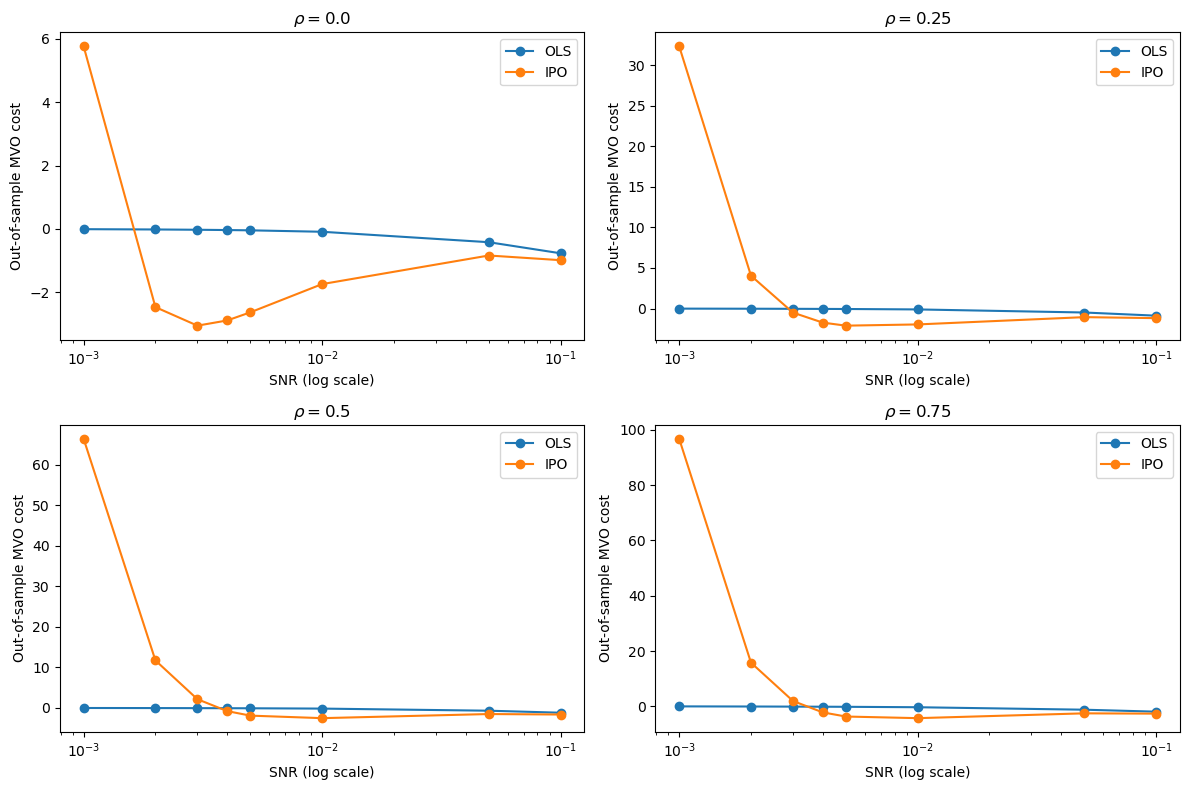

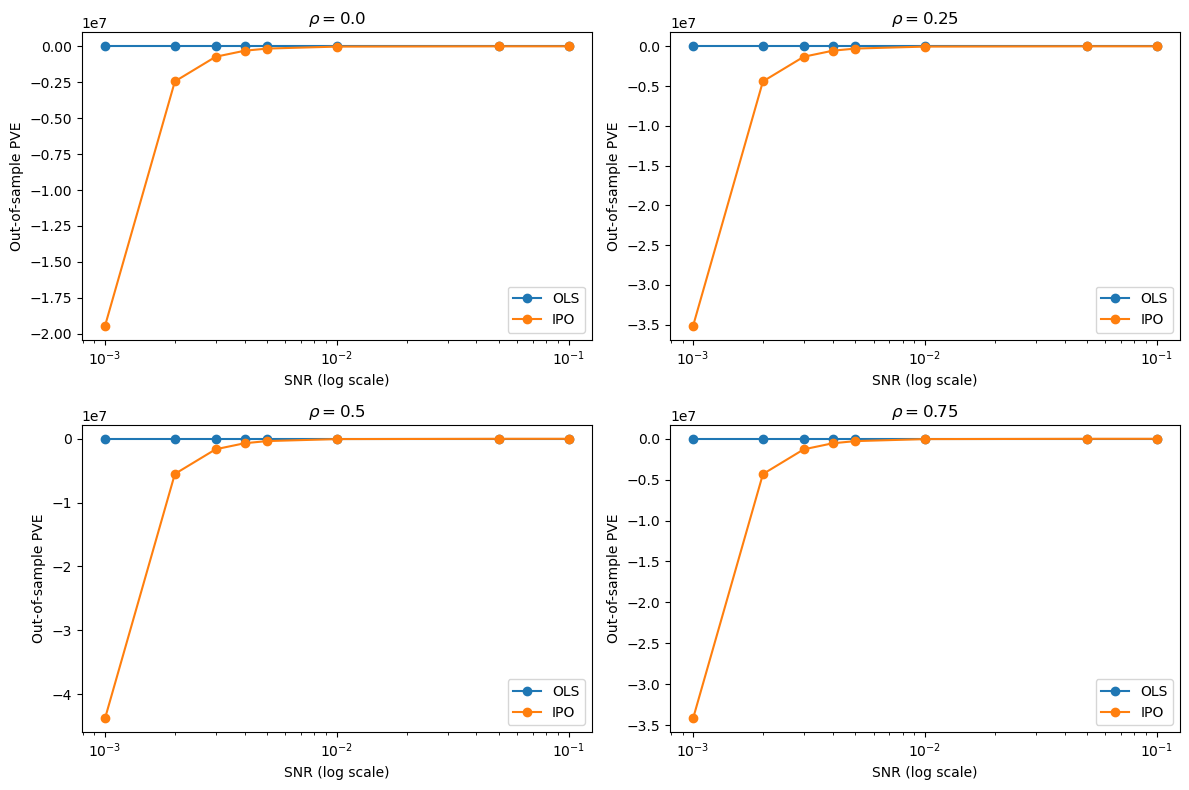

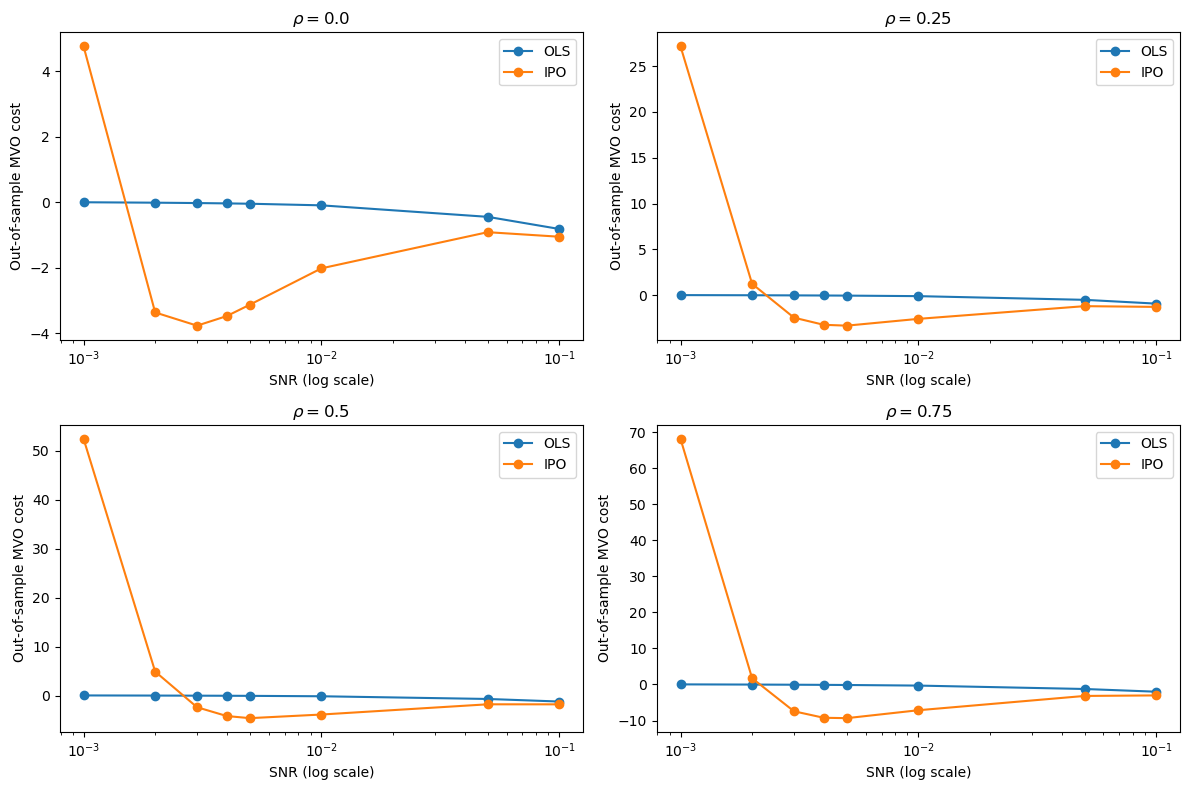

In [71]:
# Figure 2: res=20 -> s=200, cost
plot_mean_only_2x2(df_raw, s_cov=200, metric="cost")

# Figure 3: res=20 -> s=200, pve
plot_mean_only_2x2(df_raw, s_cov=200, metric="pve")

# Figure 4: res=10 -> s=100, cost
plot_mean_only_2x2(df_raw, s_cov=100, metric="cost")
